# Финальное ДЗ модуля "Построение модели"

#### Задание
Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

Импортируем библиотеки

In [625]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

import seaborn as sbs
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split

### Загружаем данные

In [626]:
df = pd.read_csv('..//data//data_final.csv')
print(df.shape)
df.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 1. Первичный анализ и предобработка данных

### 1.1 Посмотрим сверху на данные

In [627]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [628]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Есть  пустые значения, есть категориальные и числовые признаки

### 1.2 Анализируем распределения значений в признаках и распределяем фичи на группы

Просмотрим все признаки и распределим их на группы по типу признака:

In [629]:
categorical_for_one_hot = []
categorical_rest = []
numerical = []
target = []
for ftr in df.columns:
    print('Number of', ftr, 'is',df[ftr].unique().shape[0], ', Data type is', df[ftr].dtype)
    if (df[ftr].dtype=='object'):
        if (df[ftr].unique().shape[0] <= 50):
            categorical_for_one_hot.append(ftr)
        else: 
            categorical_rest.append(ftr)
    
    elif (df[ftr].dtype in ['int64', 'float64']) & (ftr != 'Item_Outlet_Sales'):
        numerical.append(ftr)
    else: target.append(ftr)
        
        

Number of Item_Identifier is 1559 , Data type is object
Number of Item_Weight is 416 , Data type is float64
Number of Item_Fat_Content is 5 , Data type is object
Number of Item_Visibility is 7880 , Data type is float64
Number of Item_Type is 16 , Data type is object
Number of Item_MRP is 5938 , Data type is float64
Number of Outlet_Identifier is 10 , Data type is object
Number of Outlet_Establishment_Year is 9 , Data type is int64
Number of Outlet_Size is 4 , Data type is object
Number of Outlet_Location_Type is 3 , Data type is object
Number of Outlet_Type is 4 , Data type is object
Number of Item_Outlet_Sales is 3493 , Data type is float64


In [630]:
print('For one-hot:',len(categorical_for_one_hot), categorical_for_one_hot)
print('rest of categorical:', len(categorical_rest), categorical_rest)
print('Numerical:',     len(numerical), numerical)
print('Target:',     len(target), target)

For one-hot: 6 ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
rest of categorical: 1 ['Item_Identifier']
Numerical: 4 ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
Target: 1 ['Item_Outlet_Sales']


Таким образом мы распределили признаки на категориальные и числовые и наметили какие как скорее всего нужно преобразовывать.

### 1.3 Посмотрим на распределение числовых признаков

In [346]:
df[numerical].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867
std,4.643456,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1985.000000
25%,8.773750,0.026989,93.826500,1987.000000
50%,12.600000,0.053931,143.012800,1999.000000
75%,16.850000,0.094585,185.643700,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


Подозрительны нули в Item_Visibility. Рассмотрим поподробнее

In [347]:
df[df.Item_Visibility==0].shape

(526, 12)

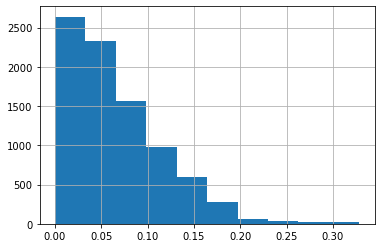

In [348]:
df.Item_Visibility.hist()

Похоже нулевые значения в проценте витрины - это округление очень маленького числа, так как относительно маленькие числа преобладают в распределении. Поэтому проблемы нет в этих нулях.

### 1.4 Анализируем и устраняем пустые значения

In [349]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Нулевые значения есть только в признаках Item_Weight и Outlet_Size. Посмотрим на них поподробнее

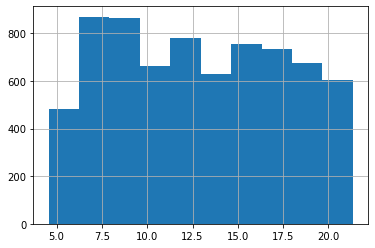

In [350]:
df['Item_Weight'].hist()

In [351]:
df[df.Item_Weight.isnull()].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


In [352]:
print('empty Weight in Outlets:', df[df.Item_Weight.isnull()].Outlet_Identifier.unique())
print('filled Weight in Outlets:', df[df.Item_Weight.notnull()].Outlet_Identifier.unique())

empty Weight in Outlets: ['OUT027' 'OUT019']
filled Weight in Outlets: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT045' 'OUT017' 'OUT046' 'OUT035']


Значение массы продукта пропущено только в двух из десяти магазинах, при чем в остальных 8 пропусков нет.
Поэтому в этих двух  магазинах заполним значения средними значениями продаж в остальных магазинах:

In [353]:
print(df[df.Item_Weight.isnull()].Item_Identifier.unique().shape)
print(df[df.Item_Weight.notnull()].Item_Identifier.unique().shape)
print('Сможем(1)/Не сможем(0) заполнить средними:\n',pd.Series([1 if i in df[df.Item_Weight.notnull()].Item_Identifier.unique() else 0 
          for i in df[df.Item_Weight.isnull()].Item_Identifier.unique()]).value_counts())

(1142,)
(1555,)
Сможем(1)/Не сможем(0) заполнить средними:
 1    1138
0       4
dtype: int64


Мы можем заполнить средними практически все пропуски кроме четырех. четыре оставшихся выбросим из выборки без потери качества.

In [354]:
mean_item_weights = (df[df.Outlet_Identifier.isin(['OUT049', 'OUT018', 'OUT010', 'OUT013', 
                               'OUT045', 'OUT017', 'OUT046', 'OUT035'])]
                        .groupby(['Item_Identifier']).mean()['Item_Weight'])
to_df = pd.DataFrame({'Item_Identifier':mean_item_weights[mean_item_weights.index.isin(df[df.Item_Weight.isnull()].Item_Identifier.unique())].index,
                      
                      'Item_Weight_mean':mean_item_weights[mean_item_weights.index.isin(df[df.Item_Weight.isnull()].Item_Identifier.unique())]})
to_df.index.name = 'Index'

In [437]:
df_new = pd.merge(df, 
                  to_df,
                  left_on='Item_Identifier',
                  right_on='Item_Identifier', how='left')
df_new.loc[df_new['Item_Weight'].isnull(), 'Item_Weight'] =  df_new.loc[df_new['Item_Weight'].isnull(),'Item_Weight_mean']
df_new.drop(columns=['Item_Weight_mean'], inplace=True)

После заполнения значений средними проверяем сколько пустых значений осталось. Должно остаться 4.

In [438]:
df_new.isnull().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

4 значения - несущественное количество - можно убрать строки из выборки без ощутимой потери качества, это сделаем чуть позже.
Пока перейдем к признаку Outlet_Size

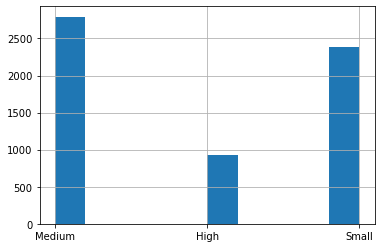

In [439]:
df['Outlet_Size'].hist()

In [440]:
print('empty Outlet_Size:', df[df.Outlet_Size.isnull()].Outlet_Identifier.unique())
print('filled Outlet_Size:', df[df.Outlet_Size.notnull()].Outlet_Identifier.unique())

empty Outlet_Size: ['OUT010' 'OUT045' 'OUT017']
filled Outlet_Size: ['OUT049' 'OUT018' 'OUT013' 'OUT027' 'OUT046' 'OUT035' 'OUT019']


В трех магазинах из 10 неизвестен размер. Можно оценить размер исходя из объема продажи.
Для этого посмотрим на савокупные объемы продаж в магазинах:

In [441]:
df_new.Outlet_Size.fillna('Unknown', inplace=True)
df_new[['Outlet_Identifier', 'Outlet_Size', 'Item_Weight']].groupby(['Outlet_Identifier', 'Outlet_Size']).sum()

,,Item_Weight
Outlet_Identifier,Outlet_Size,
OUT010,Unknown,7166.800
OUT013,High,12121.730
OUT017,Unknown,11877.495
OUT018,Medium,11946.465
OUT019,Small,6855.745
OUT027,Medium,12054.985
OUT035,Small,11931.295
OUT045,Unknown,11751.840
OUT046,Small,11966.125


Посмотрев на объемы продаж, можно очень примерно оценить какой магазин по размеру и заменить неизвестные значения выбранными:

In [442]:
fill_sizes = {'OUT010':'Small', 'OUT017':'Medium', 'OUT045':'Medium'}
for i in df[df.Outlet_Size.isnull()].Outlet_Identifier.unique():
    df_new.loc[(df_new['Outlet_Identifier'] == i) & (df_new['Outlet_Size'] == 'Unknown'), 'Outlet_Size'] = fill_sizes[i]

df_new[['Outlet_Identifier', 'Outlet_Size', 'Item_Weight']].groupby(['Outlet_Identifier', 'Outlet_Size']).sum()

,,Item_Weight
Outlet_Identifier,Outlet_Size,
OUT010,Small,7166.800
OUT013,High,12121.730
OUT017,Medium,11877.495
OUT018,Medium,11946.465
OUT019,Small,6855.745
OUT027,Medium,12054.985
OUT035,Small,11931.295
OUT045,Medium,11751.840
OUT046,Small,11966.125


Теперь удалим оставшиеся 4 строки с пустыми значениями и убедимся, что пустых  больше нет:

In [443]:
df_new.dropna(inplace=True)
print(df_new.shape)
df_new.isnull().sum()

(8519, 12)


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [444]:
df_new.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 1.5 Преобразовываем категориальные признаки

Для названия продуктов используем LabelEncoder:

In [445]:
label_encoder = LabelEncoder()
df_new['Item_Identifier'] = label_encoder.fit_transform(df_new['Item_Identifier'])
df_new.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,8,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


Для выбранных выше категориальных признаков признаков используем One-Hot (небольшое количество уникальных значений), предварительно почистив данные (есть по-разному названные одинаковые наименования в признаке Item_Fat_Content)

In [446]:
print(categorical_for_one_hot)

['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [447]:
print(df_new['Item_Fat_Content'].value_counts())
df_new.loc[:,'Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat', inplace=True)
df_new.loc[:,'Item_Fat_Content'].replace(['reg'], 'Regular', inplace=True)
print('<---------------------------->')
print(df_new['Item_Fat_Content'].value_counts())

Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
<---------------------------->
Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64


In [448]:
df_new = pd.get_dummies(df_new, columns=categorical_for_one_hot)
df_new.head(5)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,156,9.30,0.016047,249.8092,1999,3735.1380,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,8,5.92,0.019278,48.2692,2009,443.4228,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,660,17.50,0.016760,141.6180,1999,2097.2700,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,1117,19.20,0.000000,182.0950,1998,732.3800,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0
4,1293,8.93,0.000000,53.8614,1987,994.7052,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


#### Теперь наш датасет готов к более подробному анализу и построению моделей!
Выгрузим его в отдельный файл:

In [631]:
df_new.to_csv('..//data//data_final_transformed.csv')

### 1.6 Взаимосвязи между признаками и целевым значением

Построим матрицу корреляции признаков:

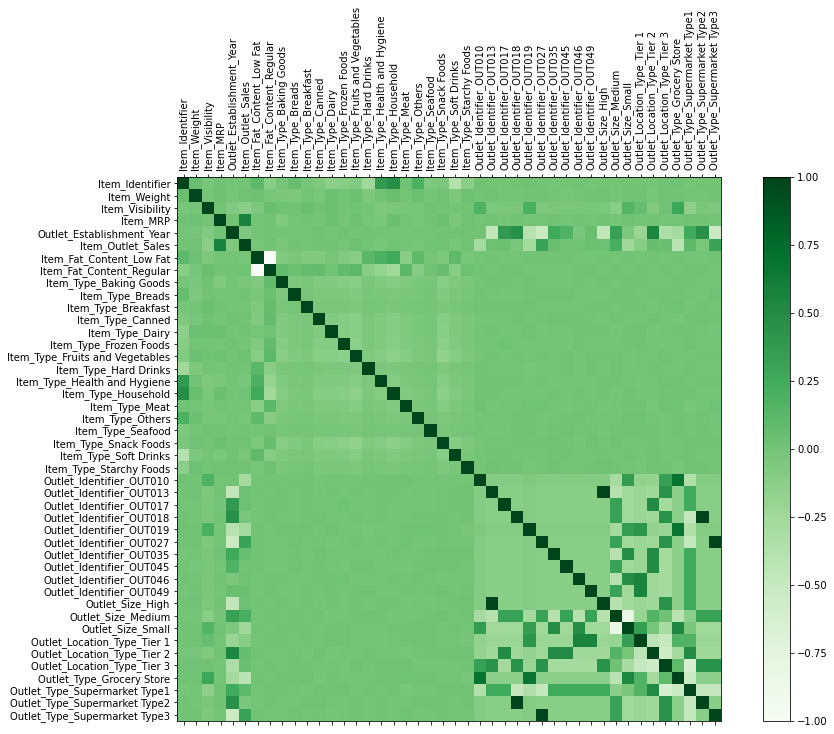

In [449]:
corr = df_new.corr()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap=plt.cm.Greens, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_new.columns)
ax.set_yticklabels(df_new.columns)
plt.show()

Визуально можно заметить, что отличная от нуля корелляция есть между целевой переменной Item_Outlet_Sales и признаками: Item_Visibility, Item_MRP, а также идентификаторами и признаками самого магазина.

# 2 Построение модели
В данном случае мы имеем дело с задачей регрессии (величина продажи может теоретически принимать любые положительные значения на вещественной оси). Поэтому в качестве метрики выбираем величину ошибки предсказания (MSE и MAE). Будем использовать две величины вместе для большей уверенности, благо, что дополнительных сложностей это не несет.

### 2.1 Выделение отложенной выборки

Отмасштабируем данные для удобства.
После этого разделим выборку на три части - train, dev и test. На train будем тренировать модели,  на dev  - валидировать, а test - отложенная выборка для финальной оценки модели.

In [456]:
features = df_new.drop(columns=['Item_Outlet_Sales']).columns
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(df_new), columns=df_new.columns)

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Item_Outlet_Sales']), 
                                                    X['Item_Outlet_Sales'], 
                                                    test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1)
print('Train:', X_train.shape, y_train.shape)
print('Dev:', X_dev.shape, y_dev.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (6900, 43) (6900,)
Dev: (767, 43) (767,)
Test: (852, 43) (852,)


### 2.2 Линейная модель

В качестве линейной модели выберу Ридж регрессию, так как она содержит регуляризацию. (В простой линейной регрессии коэффициенты получались какие-то совершенно гигантские, поэтому штраф на величину коэффициентов тут весьма осмысленен).
Буду подбирать пораметры случайным поиском по заданным массивам (силу регуляризации, количество итераций в оптимизации, точность и способ поиска решения)

In [497]:
params = {'alpha':list(np.arange(0.1, 100.0, 0.1)),
          'max_iter':[500, 1000, 2000, 5000, 10000],
          'tol':[1e-3, 1e-2, 1e-4, 1e-5],
          'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']          
          }

lin_reg = RandomizedSearchCV(Ridge(), params, cv=10, n_jobs=-1, random_state=13, n_iter=30)
lin_reg = lin_reg.fit(X_train, y_train).best_estimator_
lin_reg

Ridge(alpha=10.8, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, random_state=None, solver='sag', tol=0.001)

In [498]:
pd.DataFrame({'Actual': y_dev, 'Predicted': lin_reg.predict(X_dev), 'Diff': y_dev-lin_reg.predict(X_dev)})

,Actual,Predicted,Diff
1937,0.056169,-0.189017,0.245186
1739,-1.150254,-0.352334,-0.797921
4600,-0.231000,-0.479227,0.248227
4737,0.365578,0.916028,-0.550450
3990,0.456489,-0.002676,0.459165
...,...,...,...
6952,-0.032791,-0.315570,0.282779
4627,-0.603618,-0.888075,0.284457
2171,0.344119,0.501671,-0.157553
6198,-0.369903,0.555900,-0.925802


In [499]:
print('MSE:', np.sqrt(mean_squared_error(y_dev, lin_reg.predict(X_dev))))
print('MAE:', mean_absolute_error(y_dev, lin_reg.predict(X_dev)))

MSE: 0.6406589457134554
MAE: 0.4772392352138303


Видим, что в целом ошибка получилась более-менее адекватная на dev выборке. Посмотрим какие коэффициенты регрессии получились по модулю наибольшими - таким образом узнаем какие признаки привносят наибольший вклад в регрессионную модель:

In [513]:
pd.Series(lin_reg.coef_, index = features).abs().sort_values(ascending=False).head(20)

Item_MRP                         0.568313
Outlet_Type_Grocery Store        0.158850
Outlet_Type_Supermarket Type3    0.124687
Outlet_Identifier_OUT027         0.124687
Outlet_Identifier_OUT010         0.111405
Outlet_Identifier_OUT019         0.105442
Outlet_Identifier_OUT035         0.056905
Outlet_Identifier_OUT046         0.047086
Outlet_Size_Medium               0.043099
Outlet_Size_Small                0.043041
Outlet_Type_Supermarket Type1    0.042967
Outlet_Identifier_OUT045         0.041456
Outlet_Establishment_Year        0.023255
Outlet_Identifier_OUT018         0.020721
Outlet_Type_Supermarket Type2    0.020721
Outlet_Location_Type_Tier 1      0.019360
Item_Type_Household              0.018767
Item_Type_Seafood                0.013447
Item_Identifier                  0.012757
Outlet_Location_Type_Tier 2      0.010061
dtype: float64

Видим, что наибольший вклад вносит максимальная цена на продукт, а также понемногу характеристики магазина (в том числе некоторые конкретные наименования магазинов).

### 2.3 Нелинейная модель

В качестве нелинейной модели выберу модель случайного леса. Параметры буду подбирать также случайным поиском по массивам параметров, заданным изначально

In [501]:
params = {   'criterion': ['mse', 'mae'],
             'max_depth': list(range(5, 50, 1)),
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': list(range(1, 10, 1)),
             'min_samples_split': list(range(2, 10, 1)),
             'n_estimators': list(range(5, 100, 1)),
             'n_jobs': [-1],
             'random_state': [13]}

rf_regr = RandomizedSearchCV(RandomForestRegressor(), params, cv=10, n_jobs=-1, n_iter=30, random_state=13)
rf_regr =  rf_regr.fit(X_train, y_train).best_estimator_
rf_regr

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=28, n_jobs=-1, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

In [502]:
pd.DataFrame({'Actual': y_dev, 'Predicted': rf_regr.predict(X_dev), 'Diff': y_dev-rf_regr.predict(X_dev)})

,Actual,Predicted,Diff
1937,0.056169,-0.154471,0.210640
1739,-1.150254,-0.983840,-0.166414
4600,-0.231000,-0.567145,0.336144
4737,0.365578,0.979229,-0.613651
3990,0.456489,0.172146,0.284343
...,...,...,...
6952,-0.032791,-0.239297,0.206505
4627,-0.603618,-0.713165,0.109547
2171,0.344119,0.565744,-0.221626
6198,-0.369903,0.411430,-0.781333


In [503]:
print('MSE:', np.sqrt(mean_squared_error(y_dev, rf_regr.predict(X_dev))))
print('MAE:', mean_absolute_error(y_dev, rf_regr.predict(X_dev)))

MSE: 0.617789054497454
MAE: 0.4312382495606092


Метрики получились чуть лучше, чем в линейной модели. 
Посмотрим на значимость признаков:

In [512]:
pd.Series(rf_regr.feature_importances_, index=features).sort_values(ascending=False).head(10)

Item_MRP                           0.531213
Outlet_Type_Grocery Store          0.285127
Outlet_Establishment_Year          0.049818
Outlet_Identifier_OUT027           0.036938
Outlet_Type_Supermarket Type3      0.023837
Item_Weight                        0.019467
Item_Visibility                    0.019039
Item_Identifier                    0.016951
Item_Type_Fruits and Vegetables    0.001679
Outlet_Identifier_OUT018           0.001403
dtype: float64

Важности признков, оцененные по модели случайного леса оказались похожи на то, что мы видели на линейной модели. В частности первые два места по значимости совпадают - это максимальная цена и метка Продуктового магазина. Интересно, что третье место у моделей разное - в модели случайного леса более важным признаком является год открытия магазина (что выглядит вполне логичным). Хотя признак, который на третьем месте в линейной модели в случайном лесе тоже достаточно высоко - на пятом месте.
Посмотрим что нам даст стекинг нескольких моделей и улучшит ли он результат.

### 2.4 Стекинг
Попробуем улучшить результат нелинейной модели, используя стекинг.
Возьмем в стекинг три модели - Случайный лес из предыдущего шага, добавим к нему SV-регрессор, и финальным слоем возьмем Ридж регрессию из пункта с Линейной моделью. Возьмем те гиперпараметры, которые уже подобрали в предыдущих шагах и проверим произойдет ли улучшение качества.

In [600]:
Stack_regressor = StackingRegressor(
    [
        ('dt', RandomForestRegressor(n_estimators=28, min_samples_leaf=5, min_samples_split=7, max_depth=8,
                                     random_state=13)),
        ('svr', SVR())
    ],
Ridge(alpha=10.8, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, random_state=None, solver='sag', tol=0.001))

In [601]:
Stack_regressor = Stack_regressor.fit(X_train, y_train)

In [603]:
print('MAE')
print(mean_absolute_error(y_dev, Stack_regressor.predict(X_dev)))
print('MSE')
print(np.sqrt(mean_squared_error(y_dev, Stack_regressor.predict(X_dev))))

MAE
0.4294802401314472
MSE
0.6134050740540179


Видим, что произошло некоторое улучшение модели по сравнению со случайным лесом - значит стекинг не был бесполезен.
Поэтому для предсказания на отложенной выборке мы выберем стекинговую модель. Но как бы то ни было и Ридж и Случайный лес нам нужны для того, чтобы оценить важность предикторов, так как стекинговая модель сильно сложнее для интерпретации результатов.

# 3 Итоги

### 3.1 Оценка модели по отложенной выборке

Посмотрим оценку на отложенной выборке вместе с оценками на остальных выборках. Это даст более четкое понимание насколько хорошо обучилась модель. 

In [605]:
final_prediction = Stack_regressor.predict(X_test)

In [608]:
print('>>>>TRAIN<<<<')
print('MAE:', mean_absolute_error(y_train, Stack_regressor.predict(X_train)))
print('sqrt(MSE)', np.sqrt(mean_squared_error(y_train, Stack_regressor.predict(X_train))))
print('>>>>DEV<<<<')
print('MAE', mean_absolute_error(y_dev, Stack_regressor.predict(X_dev)))
print('sqrt(MSE)', np.sqrt(mean_squared_error(y_dev, Stack_regressor.predict(X_dev))))
print('>>>>TEST<<<<')
print('MAE', mean_absolute_error(y_test, final_prediction))
print('sqrt(MSE)', np.sqrt(mean_squared_error(y_test, final_prediction)))

>>>>TRAIN<<<<
MAE: 0.40907942235093503
sqrt(MSE) 0.5883591408467979
>>>>DEV<<<<
MAE 0.4294802401314472
sqrt(MSE) 0.6134050740540179
>>>>TEST<<<<
MAE 0.434158207112333
sqrt(MSE) 0.6199781942647088


Видим, что ошибка на отложенной выборке очень близка  к ошибке на dev-выборке - это хороший знак. А относительная близость ошибки на тренировочной и на dev выборках говорит, что сильного переобучения у нас не произошло, что тоже хорошо.

### 3.2 Определение ТОП-3 признаков больше всего влияющих на объемы продаж

Выше мы уже на линейной и нелинейной модели посмотрели на метрики важности признаков. сейчас нужно их объединить и выбрать топ-3:

Посмотрим на важности признаков в двух моделях вместе в одной таблице (из каждой модели по 10 наиболее важных):

data_dict = {'linear_importance':pd.Series(lin_reg.coef_, index = features).abs().sort_values(ascending=False).head(10),
             'non-linear_importance':pd.Series(rf_regr.feature_importances_, index=features).sort_values(ascending=False).head(10)}
pd.DataFrame(data_dict).sort_values(by='non-linear_importance', ascending=False)

Интуитивно кажется, что нелинейная модель выдала более логичный список важных признаков. Совпадение первых двух признаков нам точно позволяет поставить их на 1 и 2 место в топ, а вот 3 место нужно отдать кому-то из списка: 
* Outlet_Establishment_Year
* Outlet_Identifier_OUT027
* Outlet_Type_Supermarket Type3

Хотя Outlet_Identifier_OUT027 и Outlet_Type_Supermarket Type3 попали в топы по обеим моделям, все же я сделаю выбор в пользу более интуитивно понятного признака Outlet_Establishment_Year. Кажется достаточно естественным, что продажи могут зависеть от того, насколько новый или старый магазин.

### Итого Топ самых влияющих признаков по результатам моего анализа такой:
* Item_MRP - Максимальная цена на продукт в конкретном магазине наиболее сильно влияет на объем продаж
* Outlet_Type_Grocery Store - Объем продаж сильно зависит от того, продуктовый магазин или нет
* Outlet_Establishment_Year - Объем продаж зависит от того, насколько давно был открыт магазин.

### 3.3 Подведение итогов

Мы провели анализ имеющихся данных. Для корректного анализа заполнили пропуски в данных, используя разные подходы для признаков с пропусками (в одном случае - вычисляя среднее по подвыборке, в другом - выбирая нужную категорию исходя из дополнительного анализа другого признака).
Для преобразования категориальных признаков использовали LabelEncoder и OnehotEncoder в зависимости от количества уникальных значения признаков.


В качестве моделей использовали Линейную Ридж модель, модель случайного леса, а также стекинг этих двух моделей с добавлением третьея - SV-регрессии. 
По метрикам качества стекинг моделей показал наилучшие результаты, поэтому именно его мы использовали для оценки на отложенной выборке. 

В результате был сформирован топ признаков, влияющих на объем продаж. Это - максимальная цена на продукт, Продуктовый магазин или нет, а также год открытия магазина(старый магазин или новый).